In [1]:
#Bu defa price tahmini için RNN uygulayacağız

#import the packages
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

In [2]:
# read csv (2012'den 2021'e dataset)
dframe = pd.read_csv('bitcoin.csv')
# NaN bulunan satırları drop
dframe=dframe.dropna()

In [3]:
# tarih unix olarak tutulduğundan ve dakikaya göre değil de tarihe göre sıralama yapacağımız için düzenliyoruz
dframe['date'] = pd.to_datetime(dframe['Timestamp'],unit='s').dt.date
# tarihe göre gruplama
group = dframe.groupby('date')
# ortalamasını alma
Real_Price = group['Weighted_Price'].mean()

In [4]:
# Örneğin son 1 aylık fiyat için tahminde bulunalım
prediction_days = 30
dframe_train= Real_Price[:len(Real_Price)-prediction_days]
# son 30 günlük veri setinin bir alt kümesini test verisi olarak alıyoruz
dframe_test= Real_Price[len(Real_Price)-prediction_days:]

In [5]:
# Datayı makine öğrenmesi için normalleştirme, yeniden şekillendirme ve ölçeklendirme

# Data ön işleme
training_set = dframe_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [6]:
# RNN modelini oluşturma

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# modeli tanımlama
regressor = Sequential()

# Giriş ve LTSM (RNN mimarisi-geri bildirim yapar) katmanını ekleme
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Çıktı katmanını ekleme
regressor.add(Dense(units = 1))

# RNN'i derleme
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# RNN'i eğitim setine uydurma - ilk 100 girdiyi yazdırma
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

2022-12-24 03:27:28.250946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 03:27:33.596577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
669/669 [==============================] - 1s 1ms/step - loss: 0.0162
Epoch 2/100
669/669 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 3/100
669/669 [==============================] - 1s 937us/step - loss: 0.0105
Epoch 4/100
669/669 [==============================] - 1s 918us/step - loss: 0.0079
Epoch 5/100
669/669 [==============================] - 1s 951us/step - loss: 0.0049
Epoch 6/100
669/669 [==============================] - 1s 932us/step - loss: 0.0023
Epoch 7/100
669/669 [==============================] - 1s 903us/step - loss: 7.3120e-04
Epoch 8/100
669/669 [==============================] - 1s 924us/step - loss: 2.1993e-04
Epoch 9/100
669/669 [==============================] - 1s 921us/step - loss: 1.2755e-04
Epoch 10/100
669/669 [==============================] - 1s 907us/step - loss: 1.1027e-04
Epoch 11/100
669/669 [==============================] - 1s 904us/step - loss: 9.9595e-05
Epoch 12/100
669/669 [==============================] - 1s

In [7]:
# RNN modelimiz artık hazır ve bu modeli artık tahmin için kullanabiliriz
# Ertesi günün fiyatını tahmin etmek için bugünün fiyatını kullanacağız
# Daha uzun süre için de tahminler yapılabilir fakat etmenler çoğalacağı için hata payı fazla olur

test_set = dframe_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

1/1 [==============================] - 0s 150ms/step


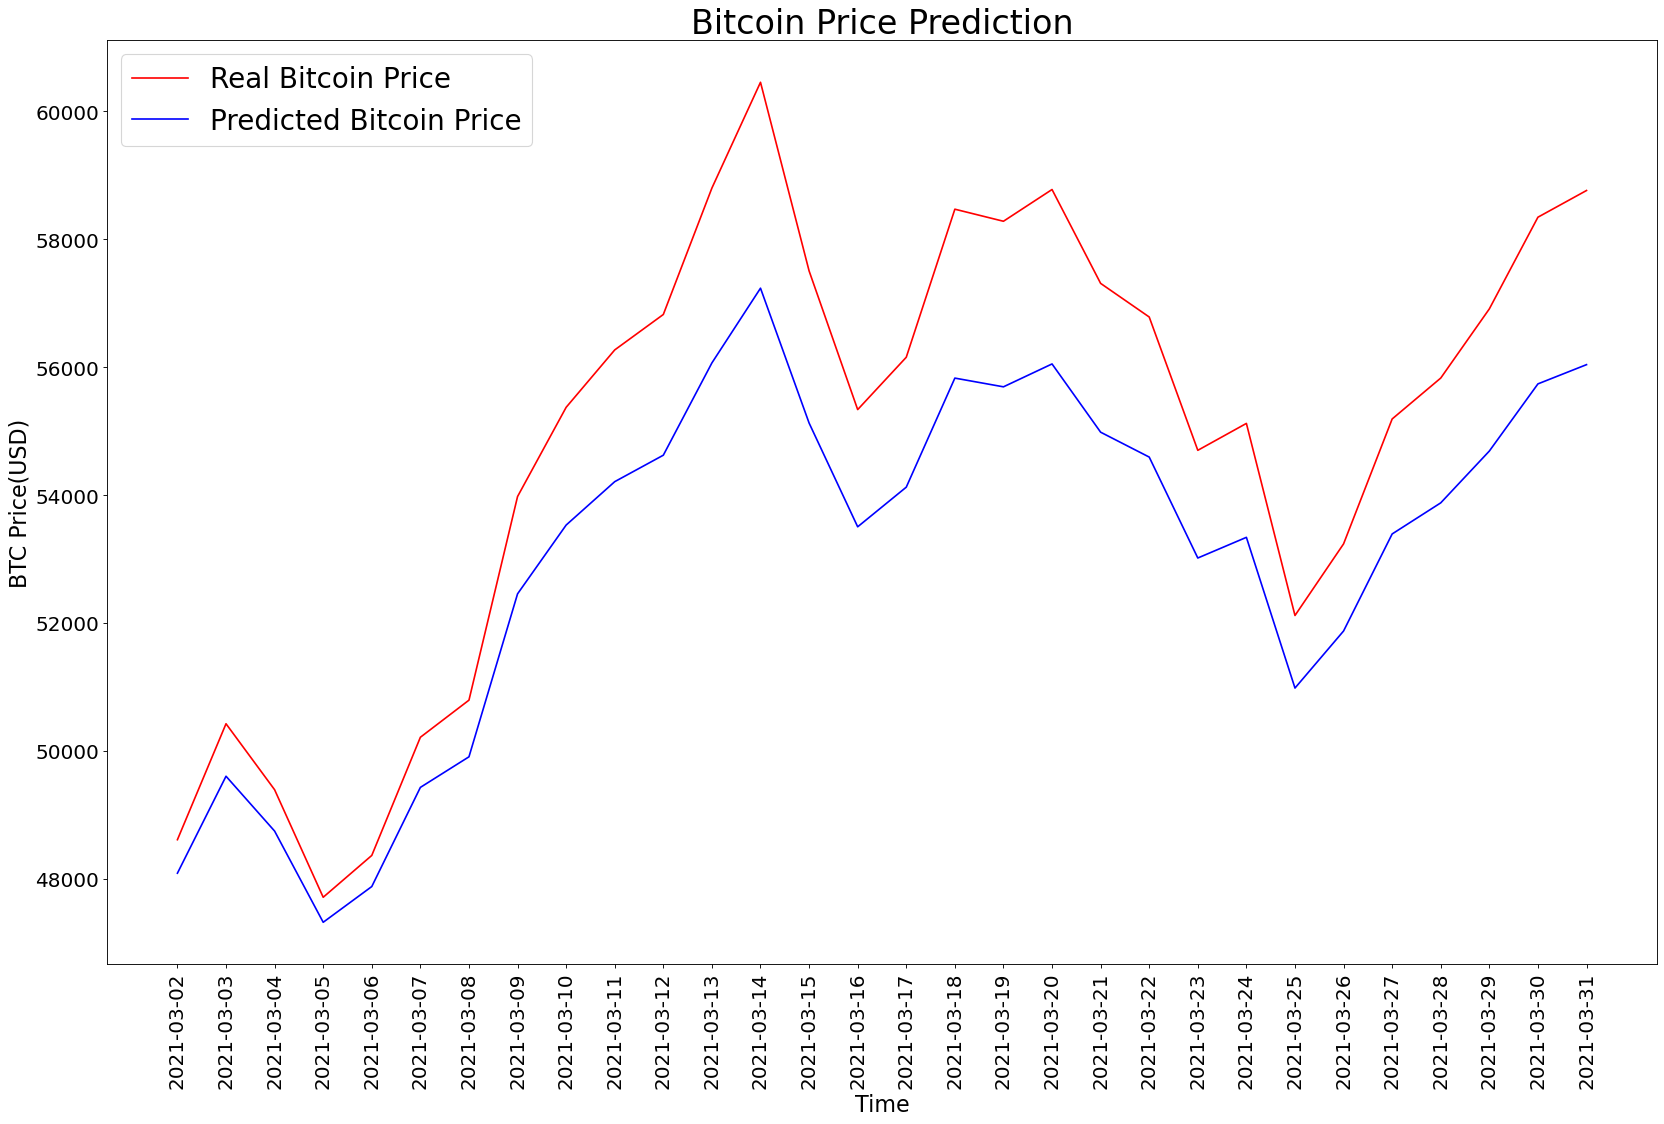

In [8]:
# sonuçları grafik olarak gösterme

plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca() 
plt.plot(test_set, color = 'red', label = 'Real Bitcoin Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction', fontsize=30)
dframe_test = dframe_test.reset_index()
x=dframe_test.index
labels = dframe_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
 tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
 tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=20)
plt.ylabel('BTC Price(USD)', fontsize=20)
plt.legend(loc=2, prop={'size': 25})
plt.show()